# Dataset
El dataset a continuación incluye todos los datos del pantano de Viñuela desde el 08/03/2018 hasta el 08/03/2023

In [ ]:
!gdown 1Ms-XgB_Hhyu3O0Y8GLIPLE2Mp4lFvaE-

Downloading...
From: https://drive.google.com/uc?id=1Ms-XgB_Hhyu3O0Y8GLIPLE2Mp4lFvaE-
To: /content/Viñuela 08-03-2018_08-03-2023.csv
100% 32.6k/32.6k [00:00<00:00, 29.8MB/s]


El siguiente dataset contiene el consumo eléctrico en los EEUU (empleado en el apartado sobre XGBoost)

In [ ]:
!gdown 1CF7AfeF02nH4se1e_NfsRtBadINk85jb

Downloading...
From: https://drive.google.com/uc?id=1CF7AfeF02nH4se1e_NfsRtBadINk85jb
To: /content/AEP_hourly.csv
100% 3.40M/3.40M [00:00<00:00, 163MB/s]


El siguiente Dataset contiene el numero de viajeros de una aerolínea entre enero de 1949 y diciembre de 1960

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-03-11 15:28:31--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-03-11 15:28:31 (38.6 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



# Kaggle
## XGBoost
Vamos a utilizar primero el dataset original, y luego cambiaremos al nuestro propio.
### Original

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


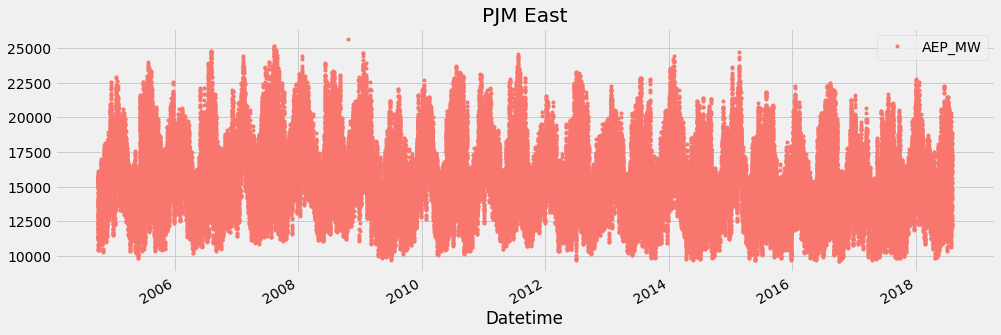

In [ ]:
pjme = pd.read_csv('/content/AEP_hourly.csv', index_col=[0], parse_dates=[0])                                 # Todos los datos (hora y consumo están en una sola hora, por lo que el indice es la columna 0 y los datos a parsear a 
                                                                                                              # datetime (según la documentacion de read_csv) también son esa columna)
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]          # Paleta de colores Rojo - Naranja - Verdes - Azules - Morado
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')                                # Función plot de Pandas 

Ahora vamos a hacer la división entre los conjuntos d eentrenamiento y comprobación

In [ ]:
split_date = '01-jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()                                                         # pandas.loc accede al dataframe según un array de valores o una etiqueta, en este caso, todos los valores menores o iguales al split_date
pjme_test = pjme.loc[pjme.index > split_date].copy()

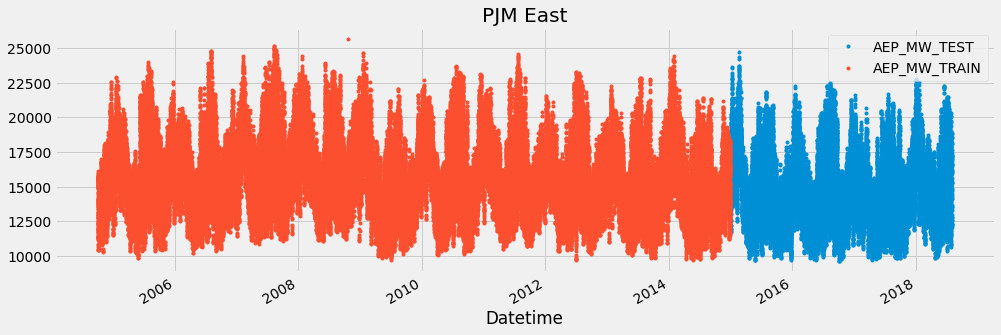

In [ ]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), lsuffix='_TEST', rsuffix='_TRAIN',how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

    # PROBLEMA: hay un cambio con el kaggle original, por algún motivo que desconozco no hace el rename y tengo que poner prefijo y sufijo

Ahora vamos a obtener las características de la serie temporal

In [ ]:
def create_features(df, label = None):
  df['date'] = df.index
  df['hour'] = df['date'].dt.hour
  df['dayofweek'] = df['date'].dt.dayofweek
  df['quarter'] = df['date'].dt.quarter
  df['month'] = df['date'].dt.month
  df['year'] = df['date'].dt.year
  df['dayofyear'] = df['date'].dt.dayofyear
  df['dayofmonth'] = df['date'].dt.day
    
  X = df[['hour','dayofweek','quarter','month','year',
         'dayofyear','dayofmonth']]
  if label:
      y = df[label]
      return X, y
  return X

Algunas lineas se han tenido que modificar debido a que dt.weekofyear y dt.week han sido descontinuadas.
Muchas de estas características luego a nosotros no nos hacen falta en absoluto, por lo que quitaremos algunas lineas después

In [ ]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')                                                    # Label ha sido cambiada debido al problema antes mencionado
X_test, y_test = create_features(pjme_test, label='AEP_MW')

Ahora vamos a crear el Modelo XGBoost

In [ ]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50)                                                                       # PREGUNTAR QUE ES ESTO
reg.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose = False)                                                                                                                  # PROBLEMA, nada del regresor deberia de dar lo que da, todo es None, pero la predicción es más o menos acertada

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

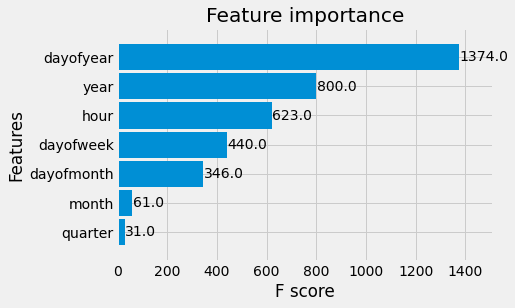

In [ ]:
_ = plot_importance(reg, height=0.9)

Ahora pasamos a las predicciones

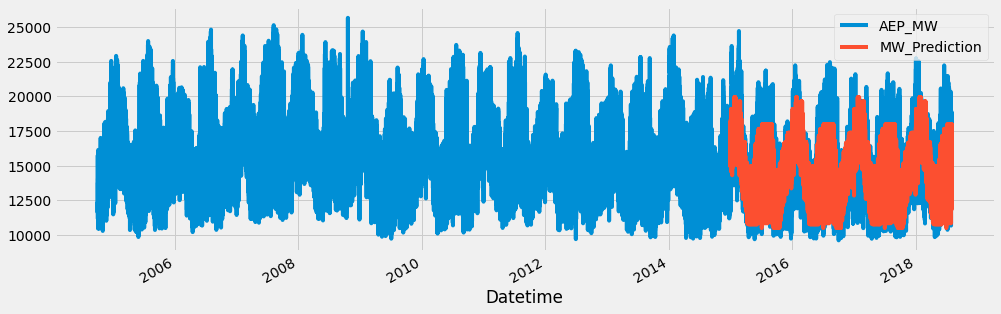

In [ ]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

Un vistazo a las predicciones

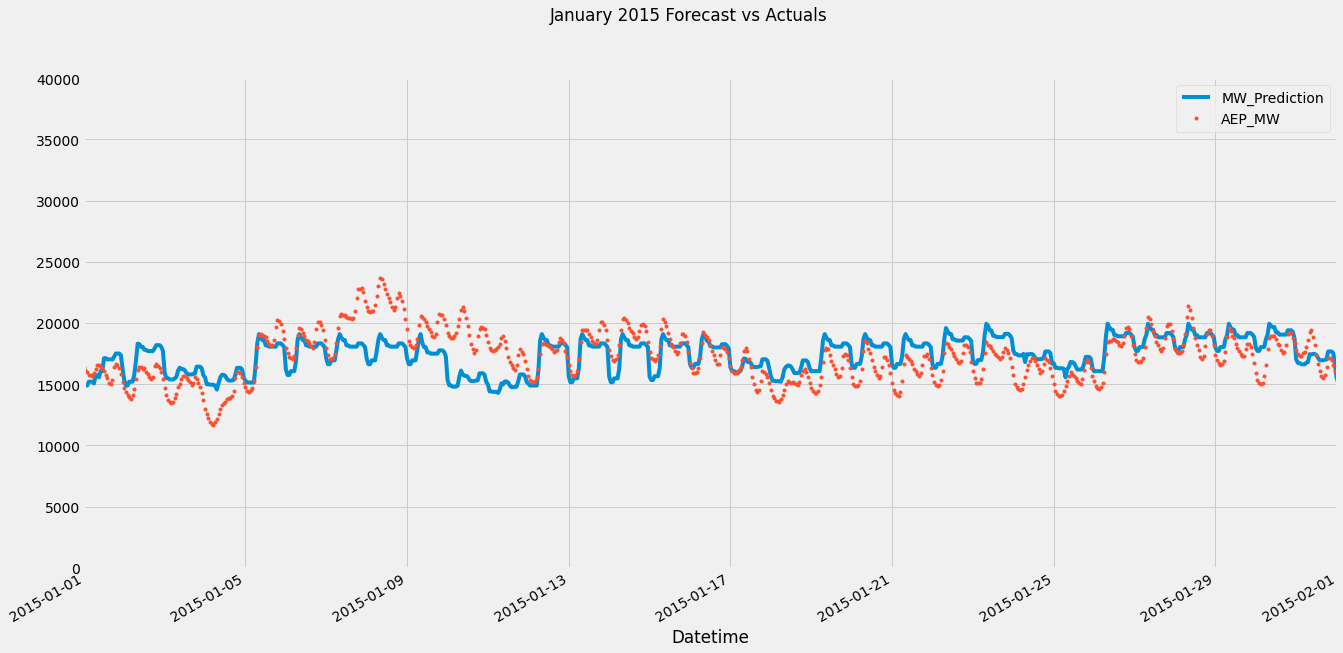

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 40000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

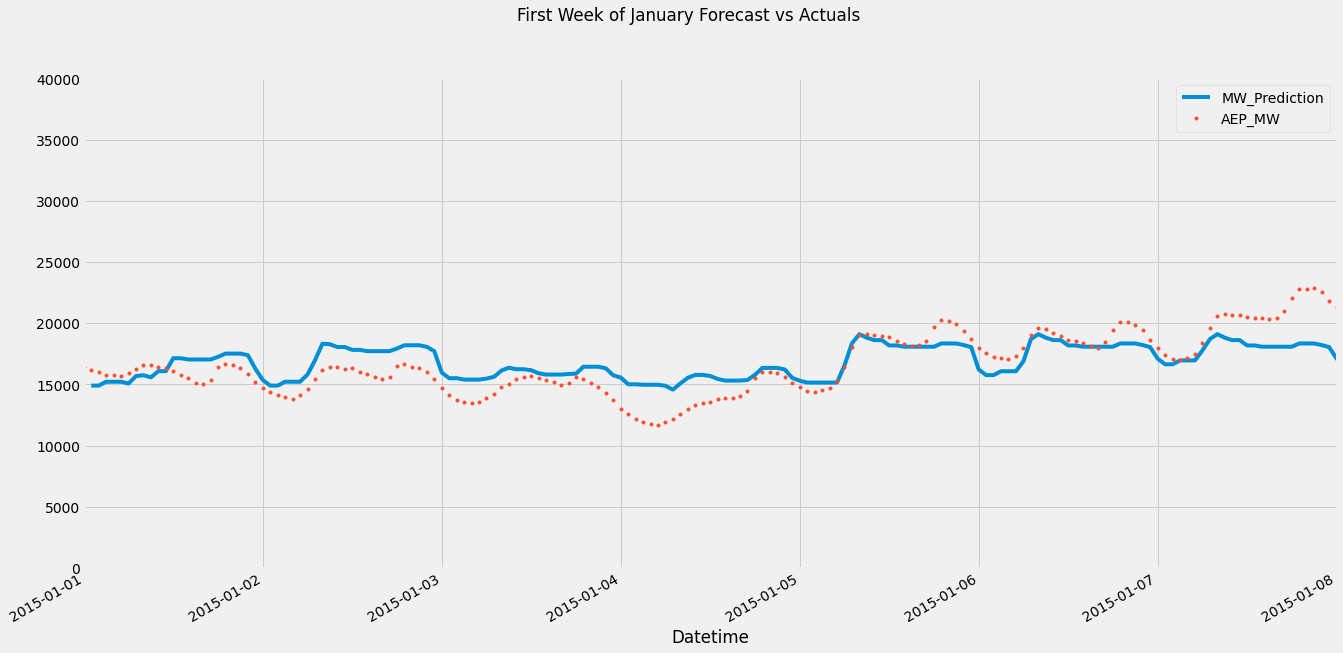

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 40000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

Los errores estadísticos serían:

In [ ]:
mean_squared_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2590010.966347909

In [ ]:
mean_absolute_error(y_true=pjme_test['AEP_MW'],
                   y_pred=pjme_test['MW_Prediction'])

1233.5804254307448

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'],
#                   y_pred=pjme_test['MW_Prediction'])                                                                               # A pesar del problema anteriormente mencionado, los errores son menores que en el ejemplo

In [ ]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['AEP_MW','MW_Prediction','error','abs_error']]

error_by_day.sort_values('error', ascending=True).head(10)                                                    # Días con errores al alza

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 2     24          13111.625000   17748.138672 -4636.512858  4636.512858
           23          13437.333333   17679.318359 -4241.984985  4241.984985
     1     25          14862.458333   18831.498047 -3969.039632  3969.039632
           23          14428.125000   18394.220703 -3966.095296  3966.095296
2018 2     23          13579.000000   17494.525391 -3915.526164  3915.526164
2015 12    25          11078.041667   14878.644531 -3800.603027  3800.603027
2017 2     7           14051.250000   17832.552734 -3781.303304  3781.303304
           22          13582.750000   17338.933594 -3756.184041  3756.184041
     1     22          12295.541667   16048.240234 -3752.698364  3752.698364
2018 2     28          14095.041667   17776.830078 -3681.787842  3681.787842

In [ ]:
error_by_day.sort_values('abs_error', ascending=False).head(10)                                                 # Peores predicciones                      

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2018 1     6           20847.833333   15565.559570  5282.273356  5282.273356
2015 2     19          22249.500000   17086.490234  5163.009644  5163.009644
           20          22047.041667   16901.697266  5145.343465  5145.343465
2017 2     24          13111.625000   17748.138672 -4636.512858  4636.512858
2018 1     7           19803.375000   15377.880859  4425.493815  4425.493815
2017 12    31          18381.750000   14076.917969  4304.831787  4304.831787
     2     23          13437.333333   17679.318359 -4241.984985  4241.984985
2015 2     16          21129.791667   17093.353516  4036.439046  4036.439046
2017 1     25          14862.458333   18831.498047 -3969.039632  3969.039632
           23          14428.125000   18394.220703 -3966.095296  3966.095296

In [ ]:
error_by_day.sort_values('abs_error', ascending=True).head(10)                                                   # Mejores predicciones

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 10    28          12723.833333   12801.519531  -77.686605  221.517415
2015 9     26          12342.541667   12556.200195 -213.658936  237.779134
     5     2           12008.083333   12132.315430 -124.231893  245.136678
2017 11    8           14602.750000   14594.604492    8.145060  263.380737
2015 9     30          13556.583333   13640.747070  -84.163452  266.680379
     4     17          13162.208333   13395.270508 -233.062459  269.509074
2016 12    22          15903.708333   15800.623047  103.085734  275.400675
     3     4           16292.791667   16472.962891 -180.170614  277.606730
2017 5     21          12105.500000   12132.423828  -26.923869  279.359172
     10    12          13403.750000   13640.747070 -236.996785  281.404500

### Ahora con los datos propios



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

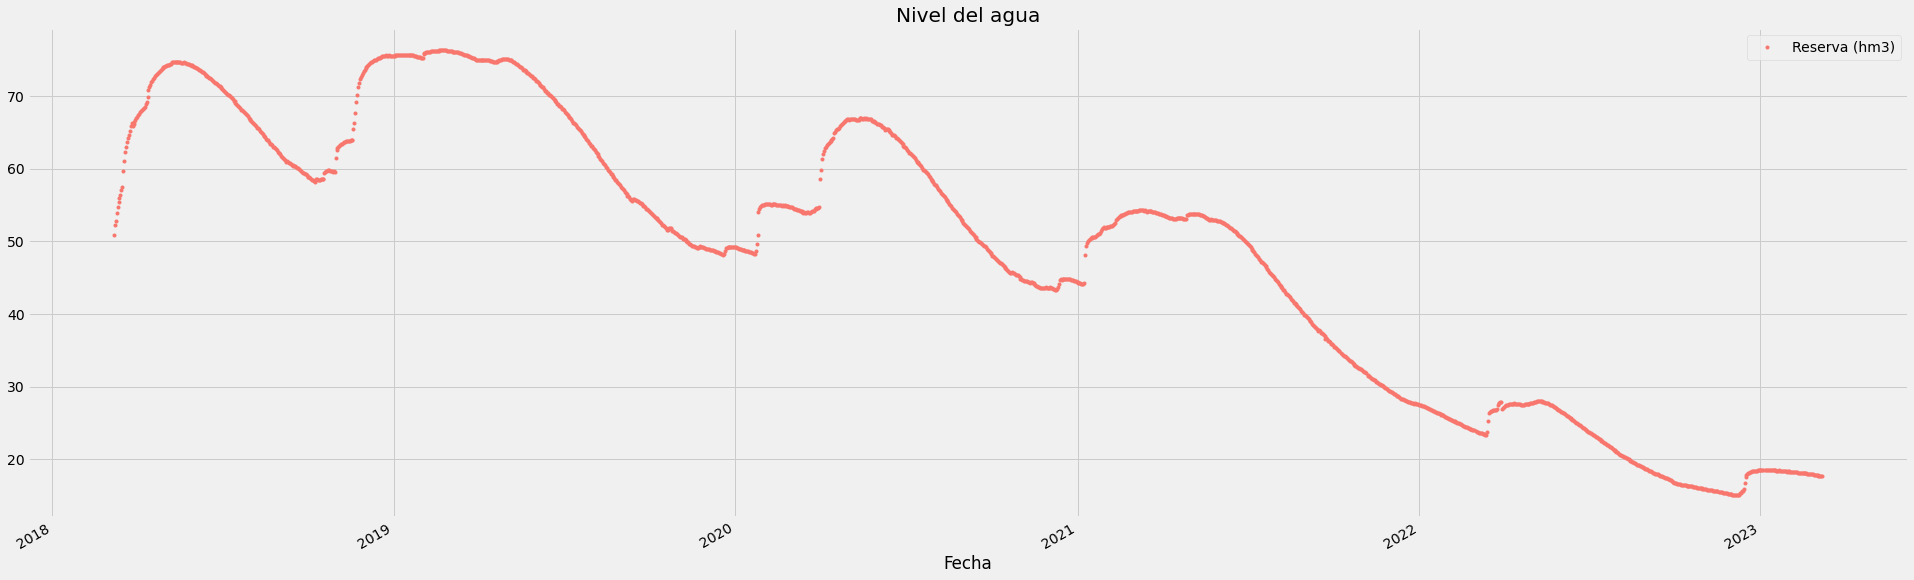

In [ ]:
waterLevels = pd.read_csv('/content/Viñuela 08-03-2018_08-03-2023.csv', index_col=[0], parse_dates=True, dayfirst=True)
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = waterLevels.plot(style='.', figsize=(30,10), color=color_pal[0], title='Nivel del agua')                                    # Nota: Joder, no me esperaba que fuera el tema TAN cuesta abajo y sin frenos
                                                                                                                                # Pregunta: No se si los puntos son por errores en las tomas de los datos o si he cometido algún fallo, no entiendo

In [ ]:
splitDate = '06-Mar-2022'
trainDF = waterLevels.loc[waterLevels.index <= splitDate].copy()
testDF = waterLevels.loc[waterLevels.index > splitDate].copy()

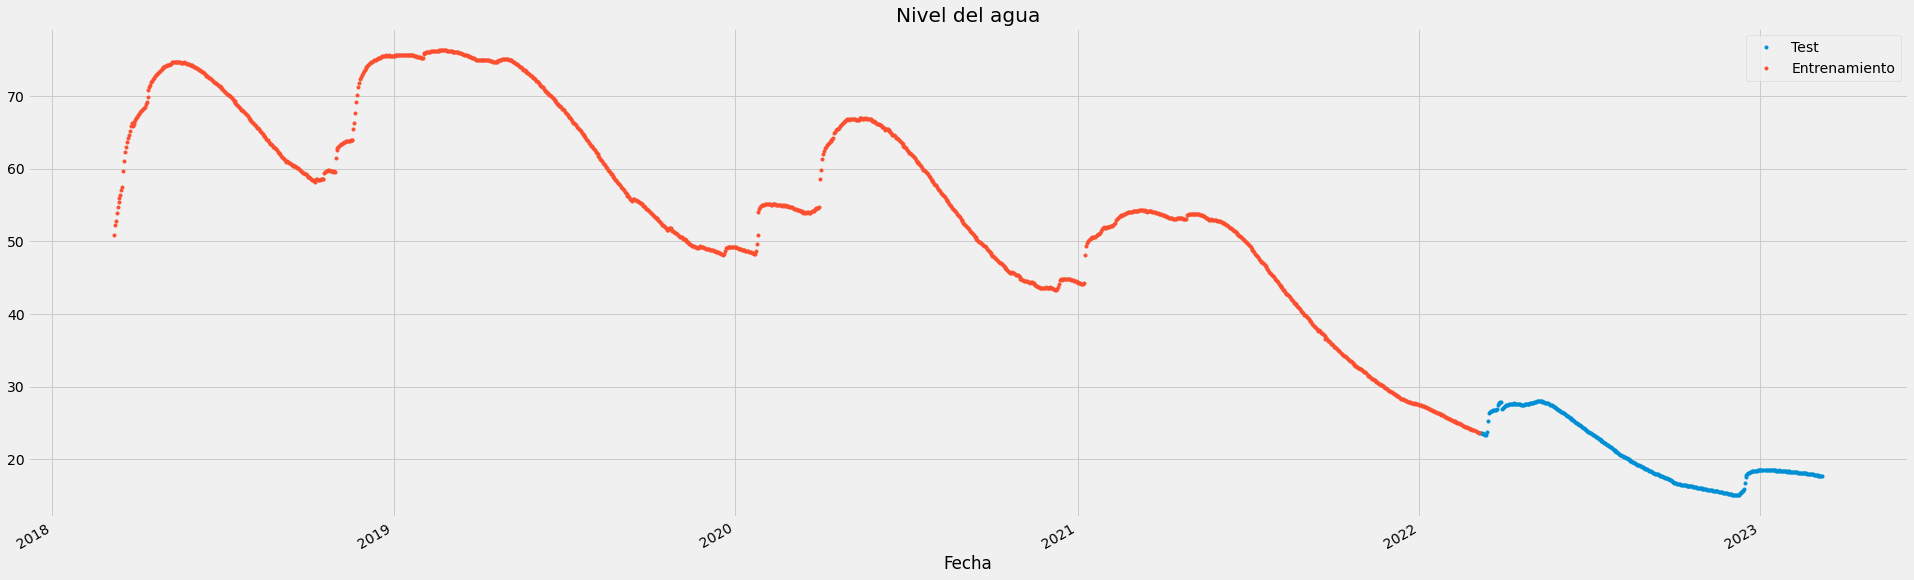

In [ ]:
_ = testDF \
    .rename(columns={'Reserva (hm3)': 'Test'}) \
    .join(trainDF.rename(columns={'Reserva (hm3)': 'Entrenamiento'}), lsuffix='_TEST', rsuffix='_TRAIN',how='outer') \
    .plot(figsize=(30,10), title='Nivel del agua', style='.')                                                                       # Por algún motivo aquí si que funciona bien

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X                                                                                                                         # He quitado lo que no me parecía

In [ ]:
X_train, y_train = create_features(trainDF, label='Reserva (hm3)')
X_test, y_test = create_features(testDF, label='Reserva (hm3)')

In [ ]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50)                                                                       # Otra vez aparece el regresor con todo vacío
reg.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

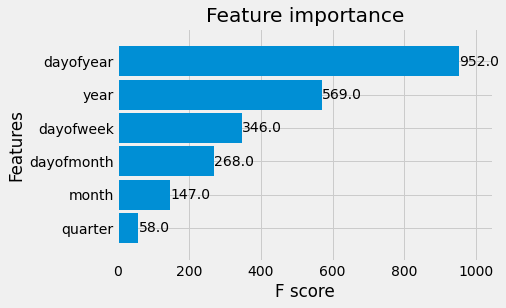

In [ ]:
_ = plot_importance(reg, height=0.9)

Nada inesperado, los dias del año, y el año en si importan más que nada, aunque no me termina de convencer que el mes y el cuatrimestre importen tan poco, creo que su importancia se notaría mucho más si hacemos la predicción sin tener el cuenta los días.

In [ ]:
testDF['Predicción'] = reg.predict(X_test)
totalDF = pd.concat([testDF, trainDF], sort=False)

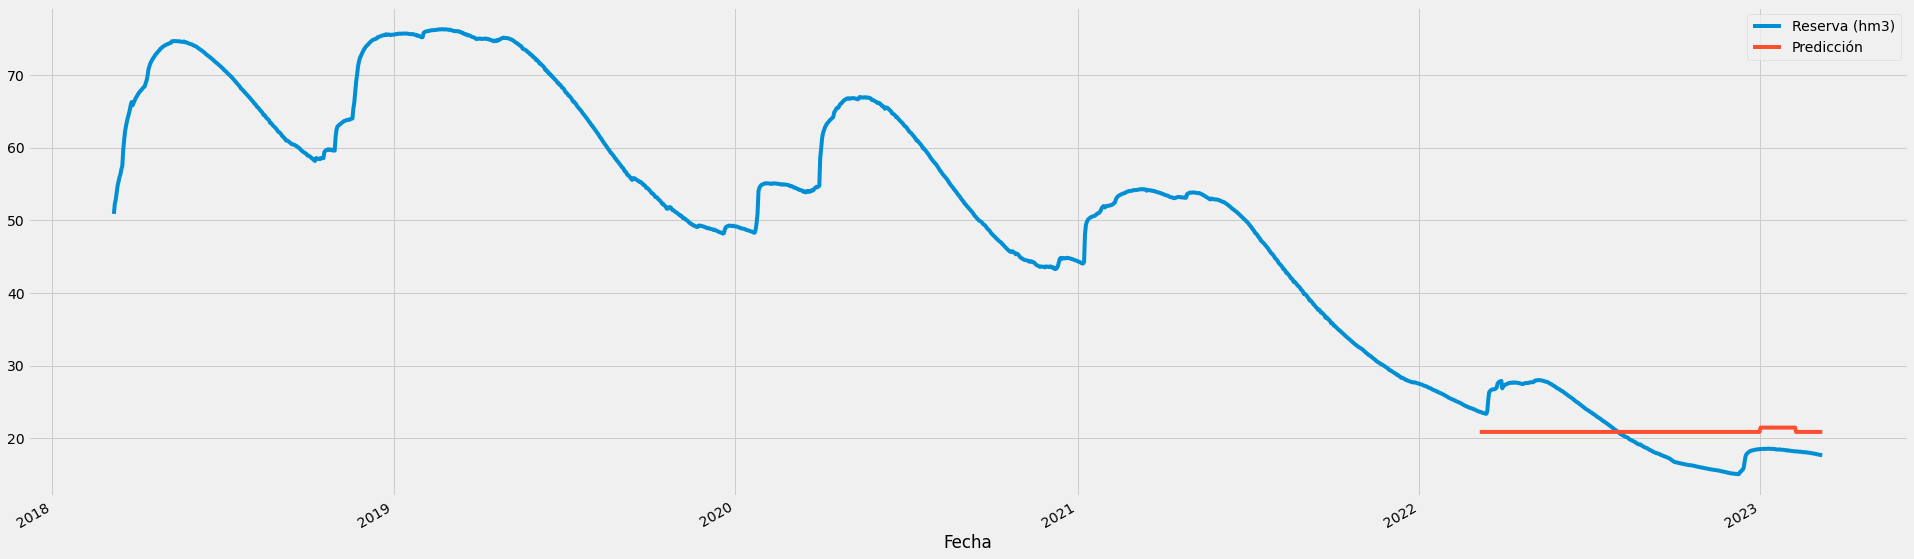

In [ ]:
_ = totalDF[['Reserva (hm3)','Predicción']].plot(figsize=(30, 10))

Aquí claramente se ve que lo de los puntos de antes es un problema, (o si me equivoco, al menos es feo de ver), ahora vamos a estudiar cómo de buena es la predicción, aunque el gran error del final no me da muchas esperanzas.

In [ ]:
mean_squared_error(y_true=testDF['Reserva (hm3)'], y_pred=testDF['Predicción'])

19.37057183662982

No se realmente si eso es bueno o malo la verdad

In [ ]:
mean_absolute_error(y_true=testDF['Reserva (hm3)'], y_pred=testDF['Predicción'])

3.9849343487465214

In [ ]:
mean_absolute_percentage_error(y_true=testDF['Reserva (hm3)'], y_pred=testDF['Predicción'])

19.409619424026577

Vale, con la fórmula de la gúia para el error porcentual, un 18% de error me parece demasiado error, aunque realmente no se si lo es o no.
Vamos a hacer como en el tutorial y revisar lo meor y lo peor de las predicciones:

In [ ]:
testDF['error'] = testDF['Reserva (hm3)'] - testDF['Predicción']
testDF['abs_error'] = testDF['error'].apply(np.abs)
error_by_day = testDF.groupby(['year','month','dayofmonth']) \
    .mean()[['Reserva (hm3)','Predicción','error','abs_error']]

In [ ]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Reserva (hm3)  Predicción     error  abs_error
year month dayofmonth                                                
2022 5     10                  27.99   20.861906  7.128094   7.128094
           9                   27.99   20.861906  7.128094   7.128094
           8                   27.99   20.861906  7.128094   7.128094
           7                   27.97   20.861906  7.108094   7.108094
           11                  27.97   20.861906  7.108094   7.108094
           12                  27.95   20.861906  7.088094   7.088094
           5                   27.93   20.861906  7.068094   7.068094
           6                   27.93   20.861906  7.068094   7.068094
           13                  27.91   20.861906  7.048094   7.048094
     3     30                  27.88   20.861906  7.018094   7.018094

Como había visto, los mayores errores son al final

In [ ]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Reserva (hm3)  Predicción     error  abs_error
year month dayofmonth                                                
2022 8     2                   20.84   20.861906 -0.021906   0.021906
           1                   20.93   20.861906  0.068094   0.068094
           3                   20.74   20.861906 -0.121906   0.121906
     7     31                  21.04   20.861906  0.178094   0.178094
     8     4                   20.61   20.861906 -0.251906   0.251906
     7     30                  21.13   20.861906  0.268094   0.268094
     8     5                   20.53   20.861906 -0.331906   0.331906
     7     29                  21.20   20.861906  0.338094   0.338094
     8     6                   20.45   20.861906 -0.411906   0.411906
     7     28                  21.33   20.861906  0.468094   0.468094

¿Qué pasan los días 9 del mes?

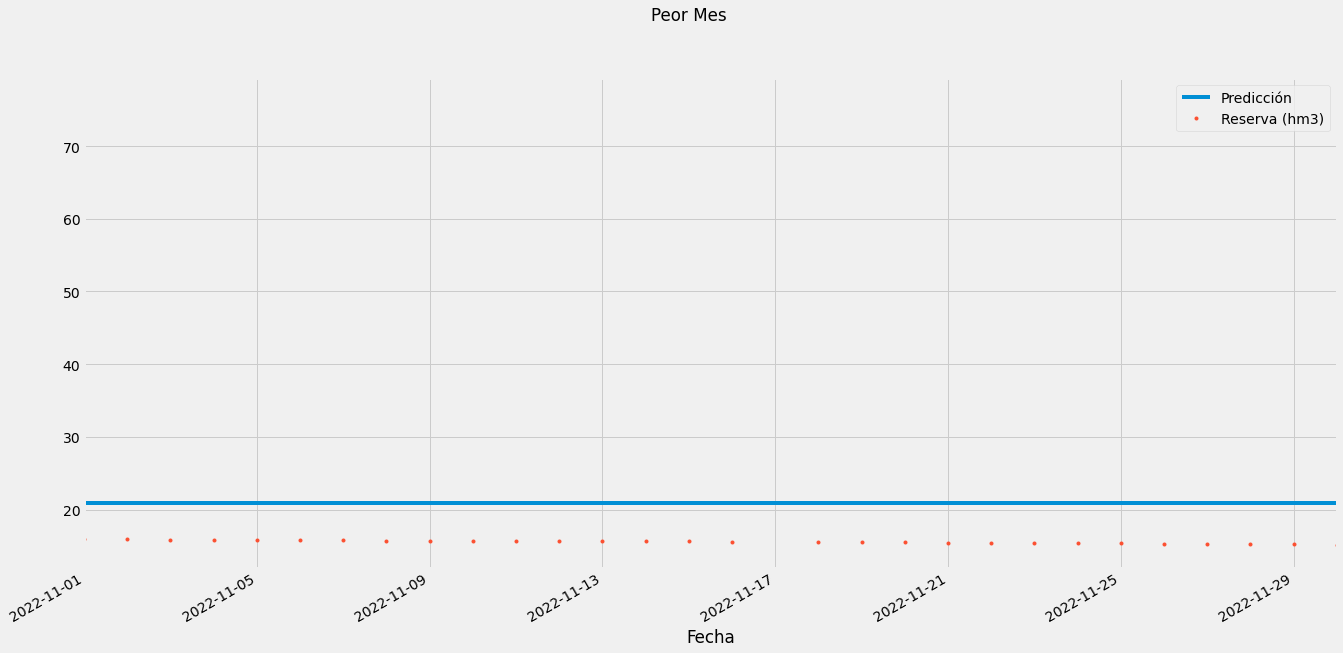

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)
_ = totalDF[['Predicción','Reserva (hm3)']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='1-Nov-2022', upper='30-Nov-2022')
plot = plt.suptitle('Peor Mes')

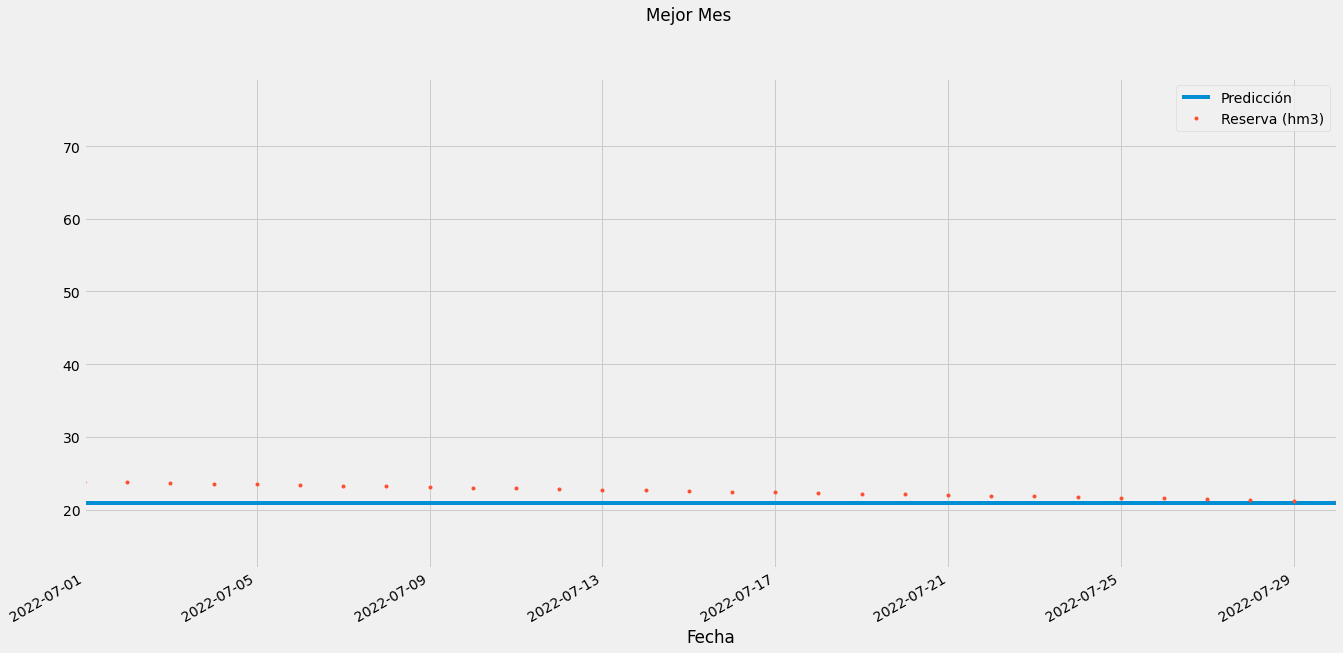

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)
_ = totalDF[['Predicción','Reserva (hm3)']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='1-Jul-2022', upper='30-Jul-2022')
plot = plt.suptitle('Mejor Mes')

Julio casi perfecto

Las preguntas finales serían entonces:


-   ¿Es buena la predicción?
-   Las dudas de repartidas por el código 



# Predicción de TS con LSTM
## Datos del tutorial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

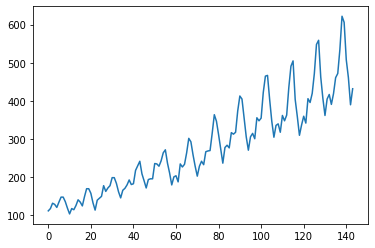

In [ ]:
training_set = pd.read_csv('/content/airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values                                  # No entiendo lo que hay entre corchetes, según la documentación ":" es para seleccionar un eje entero, pero si seleccionas los ejes 1 y 2, aquí seria lo mismo que decir "solo el eje 1"
                                                                                # porque solo están los ejes 0 y 1, asó que no sé por que hace esto
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

Carga de los datos

In [ ]:
def sliding_windows(data, seq_length):                                           # No tengo ni idea de por qué divide los datos en 2 grupos, porque con esto no está dividiendo entre Test y Train
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)                                   # Transforma los valores y los pone en un rango de entre 0 y 1, sé que es útil, pero no por qué

#training_data

In [ ]:
seq_length = 4                                                                  # Nada de lo que tenga que ver con esta función me parece que tenga sentido
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)                                                 # ¿Por qué no usar unos tamaños preestablecidos? ¿Qué se consigue haciendo esto?
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))                                     # Variable() Está obsoleto, puedo borrar esto
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Ahora el modelo LSTM en sí

In [ ]:
class LSTM(nn.Module):                                                          # nn.Module es la clase básiva de todos los módulos de redes neuronales en PyTorch
                                                                                # multi-layer long short-term memory (LSTM) documentación: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)                           # No encuentro qué es esto en la documentación

    def forward(self, x):                                                       # No entiendo por qué reescribe este método 
        h_0 = Variable(torch.zeros( 
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

Entrenamiento

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)               # Un optimizador, que sabe Dios como funciona o como interactúa con esto

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()                                                       # Sets the gradients of all optimized torch.Tensor's to zero. Signifique lo que signifique eso
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05255
Epoch: 100, loss: 0.00348
Epoch: 200, loss: 0.00295
Epoch: 300, loss: 0.00261
Epoch: 400, loss: 0.00230
Epoch: 500, loss: 0.00203
Epoch: 600, loss: 0.00185
Epoch: 700, loss: 0.00180
Epoch: 800, loss: 0.00179
Epoch: 900, loss: 0.00178
Epoch: 1000, loss: 0.00177
Epoch: 1100, loss: 0.00176
Epoch: 1200, loss: 0.00175
Epoch: 1300, loss: 0.00174
Epoch: 1400, loss: 0.00173
Epoch: 1500, loss: 0.00172
Epoch: 1600, loss: 0.00171
Epoch: 1700, loss: 0.00170
Epoch: 1800, loss: 0.00169
Epoch: 1900, loss: 0.00168


A ver, entiendo que entrena el modelo, pero no sé por qué hace falta el bucle

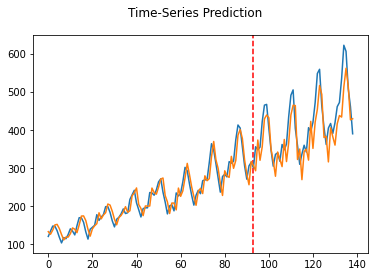

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Datos propios

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

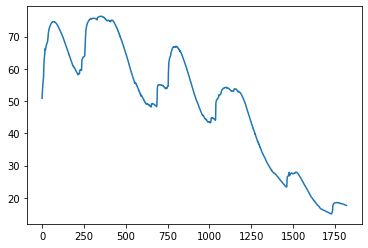

In [ ]:
training_set = pd.read_csv('/content/Viñuela 08-03-2018_08-03-2023.csv')

training_set = training_set.iloc[:,1:2].values                                  # No entiendo lo que hay entre corchetes, según la documentación ":" es para seleccionar un eje entero, pero si seleccionas los ejes 1 y 2, aquí seria lo mismo que decir "solo el eje 1"
                                                                                # porque solo están los ejes 0 y 1, asó que no sé por que hace esto
plt.plot(training_set, label = 'Nivel del agua')
plt.show()

Por algún motivo la gráfica se ve mil veces mejor ploteando así

In [ ]:
def sliding_windows(data, seq_length):                                          
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)                                  

In [ ]:
seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)                                                 
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))                                     
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):                                                          
  
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)                           

    def forward(self, x):                                                      
        h_0 = Variable(torch.zeros( 
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)              

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()                                                       
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02857
Epoch: 100, loss: 0.00008
Epoch: 200, loss: 0.00006
Epoch: 300, loss: 0.00006
Epoch: 400, loss: 0.00005
Epoch: 500, loss: 0.00005
Epoch: 600, loss: 0.00004
Epoch: 700, loss: 0.00003
Epoch: 800, loss: 0.00003
Epoch: 900, loss: 0.00004
Epoch: 1000, loss: 0.00002
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00003
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002


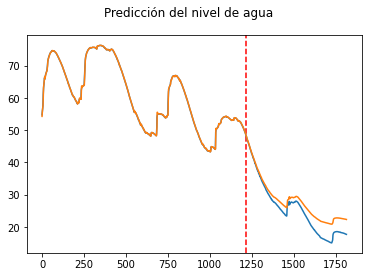

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Predicción del nivel de agua')
plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):                             # Este es el método del tutorial anterior para obtener el error
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=dataY_plot, y_pred=data_predict)

4.5222945511341095

Increible, es muchísimo mejor que antes.
También podemos ver que al contrario que la predicción anterior, ahora esperamos menos de lo que realmente és, cuando en la otra normalmente esperabamos más.
Eso sí, no me queda del todo claro cómo visualizar los datos como hicimos en el ejemplo anterior, aunque probablemente sea por falta de habilidad con los dataframes

# Red neuronal recurrente

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
training_set = pd.read_csv('/content/Viñuela 08-03-2018_08-03-2023.csv')

training_set = training_set.iloc[:,1:2].values                                  

plt.plot(training_set, label = 'Nivel del agua')
plt.show()

In [ ]:
def sliding_windows(data, seq_length):                                          
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

In [ ]:
seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.8)                                                 
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))                                     
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = nn.RNN(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)              

# Train the model
for epoch in range(num_epochs):
    outputs = rnn(trainX)
    optimizer.zero_grad()                                                       
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



AttributeError: ignored

In [ ]:
rnn.eval()
train_predict, hn = rnn(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Predicción del nivel de agua')
plt.show()

# Videos


Aquí me he dado cuenta de que aunque la idea general de lo que hacen la entiendo, en el momento en el que el más mínimo tecnicismo entra, dejo de entender lo que sea. Además, como los videos eran sobre series multivariables, pues no puedo usar mis propios datos.

# Conclusiones finales y dudas

Además de lo que hay en el código para preguntar, necesito algo que me diga en profundidad qué es lo que estoy haciendo realmente, casi todos los tutoriales que he visto montan sus modelos, pero yo en el momento en el que una clase modelo se abre, dejo de saber nada. Sumemosle que hasta el video de preprocesamiento, no tenía ni idea casi de que estaba pasando ahí, y ahora quiero pensar que sí, pero hasta que no pueda hacer un modelo de verdad no lo sabré.
Ah, y ¿LSTM es un tipo de modelo de RNN? Por lo que he visto en la documentación sí que lo es, por lo que tecnicamente la tarea de montar una predicción RNN estaría hecha, no me deja buena sensación, porque basicamente ha sido repetir lo del tutorial, y al intentar hacerlo de 0, como tenía que crear mi propio modelo, pues absolutamente nada ha funcionado.
El mejor procesamiento de datos, y su visualización han sido los hechos en la parte de XGBost, me gustaría entender mejor la diferencia, pero eso cae en lo dicho antes sobre saber manejarme muchísimo mejor con los dataframes

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
waterLevels = pd.read_csv('/content/Viñuela 08-03-2018_08-03-2023.csv', index_col=[0], parse_dates=True, dayfirst=True)

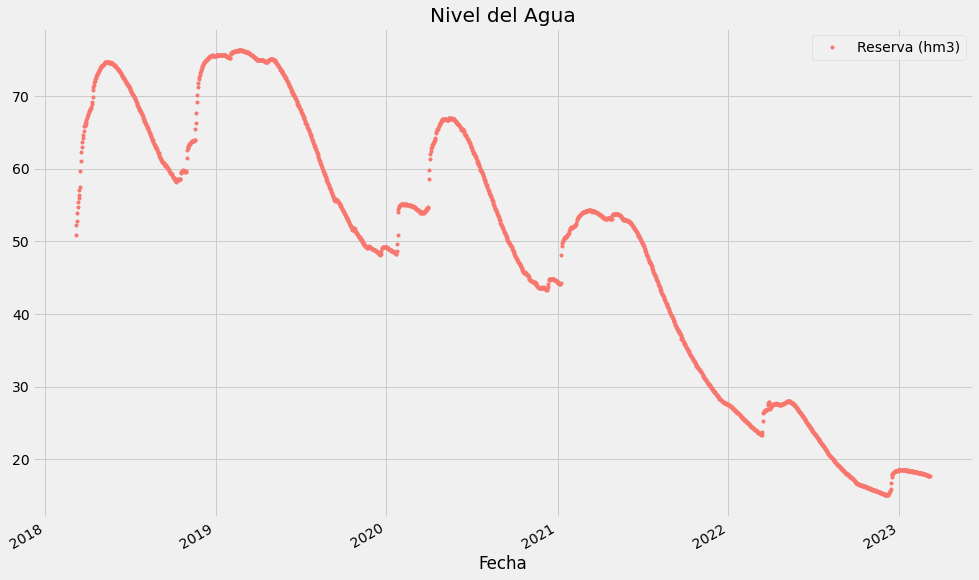

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]          # Paleta de colores Rojo - Naranja - Verdes - Azules - Morado
_ = waterLevels.plot(style='.', figsize=(15,10), color=color_pal[0], title='Nivel del Agua')